<a href="https://colab.research.google.com/github/DavinciB/child_grooming_detector/blob/main/src/SVM/3%20-%20Building%20the%20SCI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Building the SVM
Here we will aim to represent the conversations using Bag-Of-Words (BOW) with a TF-IDF weighing scheme and then build our SVM Suspicious Conversations Identifier (SCI).

First we read in the training data and labels.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import xml.etree.ElementTree as ET #for parsing the xml file
import csv #for working on csv files


def get_labels_dict(data_path): #data path the path for the dataset
    labels_dict = {} #dictionary to store conversation id and label
    with open(data_path + 'sci_labels.csv', 'r') as f:# open the labels file in reading mode
        file = csv.reader(f)#Return a reader object file which will iterate over lines in the given csvfile.
        for row in file: #for each row(line) in file set the labels dictionary
            labels_dict[row[0]] = row[1] #unique conversation id and the label
    return labels_dict # return the dictionary


def get_features_labels(root, labels_dict):#root of tree and the labels dictionary created are the parameters
    corpus = [] # each row is a string formed from all messages in a conversations
    labels = [] # each row is 0 or 1, corresponds to label for same row in corpus

    for conversation in root:
        string = " "
        for message in conversation:
            text = message.find('text').text #reading all the messages
            if text is not None:
                string = string + "\r\n" + text
                '''creating a string formed by all the messages in a conversation'''
                '''A carriage return (\r) makes the cursor jump to the first column (begin of the line) while the newline
                 (\n) jumps to the next line and eventually to the beginning of that line. So to be sure to be at the first
                  position within the next line one uses both.'''
        corpus.append(string) #appending each conversation to the list
        labels.append(int(labels_dict[conversation.get('id')])) #creating a label list ordered according to the order of conversations in corpus
    return corpus, labels #return list of conversations and labels

In [12]:
#setting the path for train data
train_data_path = '/content/drive/MyDrive/online-grooming-detector-master/data/svm_training_data/'
training_xml = ET.parse(train_data_path + 'training_data.xml') #parsing the xml file to tree
train_root = training_xml.getroot() #obtaining the root of the tree
#setting the test data path
test_data_path = '/content/drive/MyDrive/online-grooming-detector-master/data/svm_test_data/'
test_data_src = '/content/drive/MyDrive/online-grooming-detector-master/data/pan12-sexual-predator-identification-test-corpus-2012-05-21/'
test_xml = ET.parse(test_data_src + 'pan12-sexual-predator-identification-test-corpus-2012-05-17.xml') #parsing the xml file to tree
test_root = test_xml.getroot() #obtaining the root of the tree
#calling get features and get labels function
train_corpus, train_labels = get_features_labels(train_root, get_labels_dict(train_data_path)) #gets a list of conversations and labels in order
test_corpus, test_labels = get_features_labels(test_root, get_labels_dict(test_data_path)) #gets a list of conversations and labels in order

We will now represent all conversations using BOW with TF-IDF weighing scheme.
- [] Customize Vectorizer Parameters like normailize
- [] Use hashing vectorization to save space and see if performance affected (https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/)


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
# from sklearn.model_selection import train_test_split
import numpy as np

vectorizer = TfidfVectorizer() #Convert a collection of raw documents to a matrix of TF-IDF features
X_train = vectorizer.fit_transform(train_corpus)
'''Learn vocabulary and idf, return document-term matrix.This is equivalent to fit followed by transform, but more efficiently implemented. returns Tf-idf-weighted document-term matrix.'''
X_test = vectorizer.transform(test_corpus)
'''Transform raw documents to document-term matrix. returns Tf-idf-weighted document-term matrix.Uses the vocabulary and document frequencies (df) learned by fit (or fit_transform).'''

X_train = scipy.sparse.csr_matrix(X_train) #Compressed Sparse Row matrix from Tf-idf weighted document term matrix
y_train = np.array(train_labels) #Create an array of label values
X_test = scipy.sparse.csr_matrix(X_test)
y_test = np.array(test_labels)

# X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=87)
# print("Train data shape:{}\r\nTest data shape:{}".format(X_train.shape, X_test.shape))

We can now build the SVM and do cross validation to explore the accuracy of each kernel and hyperparameter.

linear, c=0.1, Accuracy: 0.9917218543046358
linear, c=0.2, Accuracy: 0.9937086092715232
linear, c=0.30000000000000004, Accuracy: 0.9943708609271523
linear, c=0.4, Accuracy: 0.994701986754967
linear, c=0.5, Accuracy: 0.9950331125827814
linear, c=0.6, Accuracy: 0.995364238410596
linear, c=0.7000000000000001, Accuracy: 0.995364238410596
linear, c=0.8, Accuracy: 0.9953642384105962
linear, c=0.9, Accuracy: 0.9954304635761589
linear, c=1.0, Accuracy: 0.995364238410596
linear, c=1.1, Accuracy: 0.995364238410596
linear, c=1.2000000000000002, Accuracy: 0.9952980132450332
linear, c=1.3000000000000003, Accuracy: 0.9952980132450332
linear, c=1.4000000000000001, Accuracy: 0.9954304635761589
linear, c=1.5000000000000002, Accuracy: 0.9954966887417218
linear, c=1.6, Accuracy: 0.9955629139072848
linear, c=1.7000000000000002, Accuracy: 0.9955629139072848
linear, c=1.8000000000000003, Accuracy: 0.9955629139072848
linear, c=1.9000000000000001, Accuracy: 0.9955629139072848
linear, c=2.0, Accuracy: 0.995562

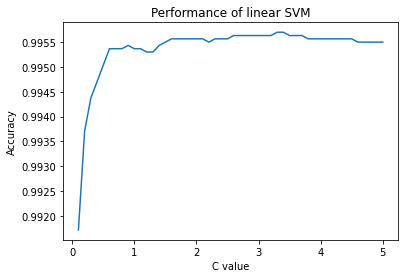

Best performing linear kernel SVM: C=3.3000000000000003, Acc=0.9956953642384105


In [18]:
from sklearn import svm
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn import metrics
import heapq
import operator
import numpy as np
from sklearn.svm import LinearSVC

num_fold = 10
k_fold = KFold(num_fold, True, 1)
kernel = 'linear'
acc = []

for coef_c in np.arange(0.1, 5.1, 0.1):#return evenly spaced values within the given arrangement start 0.1 stop 5.1 step 0.1
    acc_arr = np.zeros(num_fold)#return a new array of specified size and shape containing only zeros
    ind = 0# !!!!!!check if count!!!!!!!!
    for train_rows, val_rows in k_fold.split(X_train):#Generate indices to split data into training and test set.
#         model = svm.SVC(kernel=kernel, C=coef_c, gamma='auto', random_state=0)
        model = LinearSVC(random_state=0, C=coef_c, loss='squared_hinge', dual=True)
        model.fit(X_train[train_rows], y_train[train_rows])
        pred_y = model.predict(X_train[val_rows])
        acc_arr[ind] = metrics.accuracy_score(y_train[val_rows], pred_y)
        ind += 1
    acc.append([coef_c, np.mean(acc_arr)])
    print("{}, c={}, Accuracy: {}".format(kernel, coef_c, acc[len(acc)-1][1]))
plt.plot([i[0] for i in acc], [i[1] for i in acc])
plt.title("Performance of {} SVM".format(kernel))
plt.xlabel("C value")
plt.ylabel("Accuracy")
# plt.savefig('../output/As1_Qn4.2_' + kernel + '_' + datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.png')
plt.show()
best = heapq.nlargest(1, acc, key=operator.itemgetter(1))[0]
print("Best performing linear kernel SVM: C={}, Acc={}".format(best[0], best[1]))

Now that we have the best linear kernel model, let us test against our test data.

In [23]:
print(best[0])
model = LinearSVC(random_state=0, C=best[0], loss='squared_hinge', dual=True)
model.fit(X_train, y_train)
pred_y = model.predict(X_test)
print(metrics.accuracy_score(y_test, pred_y))

3.3000000000000003
0.9851026249290908


In [27]:
import pickle
import datetime

# save the model to the models folder
filename = '/content/drive/MyDrive/online-grooming-detector-master/models/SCI_SVM_' + "{:.2f}_".format(metrics.accuracy_score(y_test, pred_y)) + datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.sav'
pickle.dump(model, open(filename, 'wb'))